In [1]:
import tensorflow as tf
import os
import sys
import go_datafile_reader
import model
import numpy as np
import model_eval

tf.compat.v1.disable_v2_behavior()

# reload(model)
# reload(go_datafile_reader)
# reload(model_eval)

2021-11-15 23:43:42.835884: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-15 23:43:42.835904: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
train_dir = "/home/shihao/BCode/GoCNN/data/input_samples_all"
# test_dir = "/home/justin/Programming/GoAI/MovePredictionCNN/data/input/test"
test_dir = train_dir
ckpt_path = "/home/shihao/BCode/GoCNN/board_eval_cnn_5layer.ckpt"

In [5]:
train_files = []
for subdir, dirs, files in os.walk(train_dir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".dat"):
            train_files.append(filepath)

test_files = []
for subdir, dirs, files in os.walk(test_dir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".dat"):
            test_files.append(filepath)

print("num train: %d, num test: %d" %(len(train_files), len(test_files)))

num train: 93, num test: 93


In [6]:
#note you may have to change the os limit for number of open files to use the RandomAccessFileReader
#you can do this with the command "sudo ulimit -n 20000"
#if sudo can't find the ulimit command try the following below
#sudo sh -c "ulimit -n 20000 && exec su $LOGNAME"

# reader = go_datafile_reader.RandomAccessFileReader(train_files)
reader = go_datafile_reader.GoDatafileReader(train_files)
test_reader = go_datafile_reader.GoDatafileReader(test_files)

test_reader.num_epochs = 0
test_features = []
test_targets = []
test_move_numbers = []
while(test_reader.num_epochs == 0):
    test_move_numbers.append(test_reader.move_index)
    final_state, _, feature_cube = test_reader.read_sample()
    test_features.append(feature_cube)
    test_targets.append(final_state)

In [7]:
x, ownership = model.place_holders()
y_conv = model.model(x)
loss = model.loss_function(ownership, y_conv)
train_op = model.train_step(loss)

prediction = tf.round(y_conv)
correct_prediction = tf.equal(ownership, prediction)
correct_count = tf.reduce_sum(tf.cast(correct_prediction, "float"))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.initialize_all_variables())
saver = tf.compat.v1.train.Saver(tf.compat.v1.all_variables())
# saver.restore(sess, ckpt_path)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Please use tf.global_variables instead.


2021-11-15 23:44:24.135213: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-15 23:44:24.135565: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-15 23:44:24.139775: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-15 23:44:24.152922: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-15 23:44:24.152953: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (shihao-T490V2): /proc/driver/nvidia/version does not exist
2021-11

In [8]:

training_accuracies = []
test_accuracies = []
checkpoint_duration = 100
for k in range(1000):
    x_batch, y_batch = reader.get_batch(50)
    _, loss_value, y_value = sess.run([train_op, loss, y_conv], feed_dict={x:x_batch, ownership:y_batch})
    if k % 10 == 0:
        acc = accuracy.eval(feed_dict={x:x_batch, ownership:y_batch})
        training_accuracies.append(acc)
        print(f'{k}, {loss_value}, {acc}')
            
    if k % checkpoint_duration == 0:
        test_accuracy = model_eval.test_accuracy(test_features, test_targets, x, ownership, correct_count)
        test_accuracies.append(test_accuracy)
        print(f"Test accuracy: {test_accuracy}")
    if k % checkpoint_duration == 0:
        print("Saving Checkpoint...")
        saver.save(sess, ckpt_path)
    

0, 0.4878888428211212, 0.5016620755195618
Test accuracy: 0.500110725621909
Saving Checkpoint...
10, 0.4761830270290375, 0.5202770233154297
20, 0.4460555613040924, 0.5306371450424194
30, 0.4411310851573944, 0.5336841940879822


KeyboardInterrupt: 

In [25]:
import matplotlib.pyplot as plt
import numpy as np

In [26]:
def rolling_mean(number_list, window = 20):
    means = np.zeros(len(number_list))
    for i in range(len(means)):
        sub_window = number_list[i-window+1:i+1]
        means[i] = np.mean(sub_window)
    return means

100


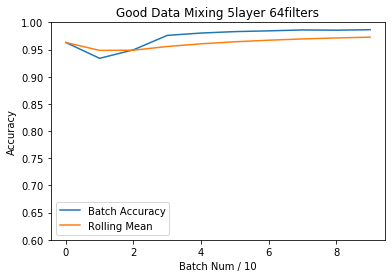

In [27]:
print(len(training_accuracies))
means = rolling_mean(test_accuracies, 20)
plt.plot(test_accuracies, label="Batch Accuracy")
plt.plot(means, label= "Rolling Mean")
plt.title("Good Data Mixing 5layer 64filters")
plt.xlabel("Batch Num / 10")
plt.ylabel("Accuracy")
plt.ylim([.6,1])
plt.legend(loc=3)
plt.show()

In [28]:
accuracies = []
y_trues = []
y_preds = []
feature_cubes = []
for i in range(len(test_features)):
    if i%500 == 0:
        print(i)
    x_, y_ = test_features[i], test_targets[i]
    y_val, y_pred, acc = sess.run([y_conv, prediction, accuracy], feed_dict={x:[x_], ownership:[y_]})
    accuracies.append(acc)
    y_trues.append(np.reshape(y_, [19,19]))
    y_preds.append(np.reshape(y_pred[0], [19,19]))
    feature_cubes.append(x_)

0
500


In [52]:
print(len(y_preds))
idx= 630
y_pred = y_preds[idx]
y_true = y_trues[idx]
feature_cube = feature_cubes[idx]

print(test_move_numbers[idx])
print(accuracies[idx])
model_eval.print_info(feature_cube = feature_cube, y_pred = y_pred, y_true = y_true)

    

850
14
0.9639889
*******************   0000001111111111111   0000001111111111111
*******************   0000011111111111111   0000011111111111111
***0*********1*1***   0000111111111111111   0000111111111111111
****************1**   0000011111111110110   0000011111111110110
**1************01**   0000011111111110100   0000011111111110100
****************0**   0000011111111110000   0000001111111110000
***************0***   1110000011111100100   1010000011111100100
*******************   1111100000111111100   1111100000111111100
*******************   1111100000001111000   1111100000001111000
*******************   1111100000000110000   1111100000000110000
****************0**   0111111000000110000   1111100010000110000
*******************   1011011011000011000   1111000011000011000
*******************   1111111110000010000   1111111110000010000
****************0**   0111111111100000000   1111111111100000000
*******************   1100101111100000000   1100100111100000000
***0************1**   1

In [30]:
import pandas as pd

In [31]:
df = pd.DataFrame()
df["Move Num"] = test_move_numbers
df["Accuracy"] = accuracies
grouped = df.groupby("Move Num").aggregate(np.mean)


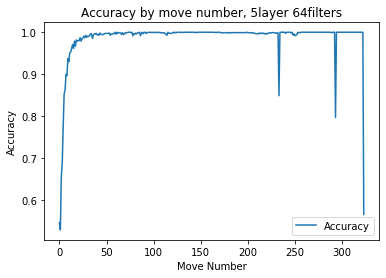

In [32]:
grouped.plot()
plt.title("Accuracy by move number, 5layer 64filters")
plt.xlabel("Move Number")
plt.ylabel("Accuracy")
plt.show()

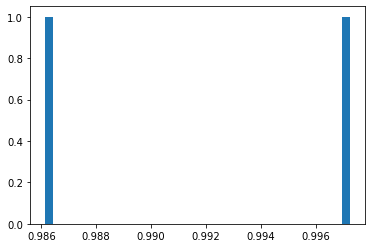

In [33]:
plot = plt.hist(df[df["Move Num"] == 250]["Accuracy"].values, bins = 40)
plt.show()